In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
import pprint
import csv
import ast
import sys


from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

import re

In [3]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
#sys.path.insert(0, '../..')



import sparql_functions as spqf

In [5]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20240316_232503'

In [6]:
## define SPARQL enpoint
endpoint = "https://query.wikidata.org/sparql"

In [132]:
query = """
SELECT DISTINCT ?item ?itemLabel ?coordinates ?battle_date ?start_time ?end_time
    WHERE {
        {
          {?item wdt:P31 wd:Q178561.
                 OPTIONAL {?item wdt:P625 ?coordinates.
                          ?item wdt:P585 ?battle_date}
                 OPTIONAL {?item wdt:P580 ?start_time;
                            wdt:P582 ?end_time}         
      FILTER(bound(?battle_date))

      # BIND(xsd:integer(REPLACE(str(?battle_date), "(.*)([0-9]{4})(.*)", "$2")) AS ?battle_year)
      
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
        }  
      }
    }  
"""

In [133]:
### Execute the SPARQL query
qr = spqf.get_json_sparql_result(endpoint,query)


<class 'dict'>


In [134]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

6430


[['http://www.wikidata.org/entity/Q283015',
  'Battle of Beaugency',
  'Point(1.64917 46.7958)',
  '1429-06-26T00:00:00Z',
  '1429-07-04T00:00:00Z',
  '1429-07-05T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q426227',
  'Third Battle of Ypres',
  'Point(3.021111111 50.900277777)',
  '1917-11-10T00:00:00Z',
  '1917-07-31T00:00:00Z',
  '1917-11-10T00:00:00Z'],
 ['http://www.wikidata.org/entity/Q281145',
  'Battle of Firebase Anaconda',
  'Point(66.0 32.13333333)',
  '2007-08-08T00:00:00Z',
  '2007-08-08T00:00:00Z',
  '2007-08-08T00:00:00Z']]

In [135]:
df_b = pd.DataFrame(r)
df_b.columns = ['uri', 'label', 'geo_coordinates', 'battle_date', 'start_time', 'end_time']
df_b.head()

,uri,label,geo_coordinates,battle_date,start_time,end_time
0,http://www.wikidata.org/entity/Q283015,Battle of Beaugency,Point(1.64917 46.7958),1429-06-26T00:00:00Z,1429-07-04T00:00:00Z,1429-07-05T00:00:00Z
1,http://www.wikidata.org/entity/Q426227,Third Battle of Ypres,Point(3.021111111 50.900277777),1917-11-10T00:00:00Z,1917-07-31T00:00:00Z,1917-11-10T00:00:00Z
2,http://www.wikidata.org/entity/Q281145,Battle of Firebase Anaconda,Point(66.0 32.13333333),2007-08-08T00:00:00Z,2007-08-08T00:00:00Z,2007-08-08T00:00:00Z
3,http://www.wikidata.org/entity/Q331565,Siege of Breisach,Point(7.58028 48.03278),1638-12-17T00:00:00Z,1638-08-18T00:00:00Z,1638-12-17T00:00:00Z
4,http://www.wikidata.org/entity/Q276852,Battle of Slivice,Point(14.0472 49.6433),1945-05-12T00:00:00Z,1945-05-11T00:00:00Z,1945-05-12T00:00:00Z


In [136]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              6430 non-null   object
 1   label            6430 non-null   object
 2   geo_coordinates  6430 non-null   object
 3   battle_date      6430 non-null   object
 4   start_time       6430 non-null   object
 5   end_time         6430 non-null   object
dtypes: object(6)
memory usage: 301.5+ KB


In [138]:
### isoler le premier caractère de la date
bd = df_b.iloc[0]['battle_date']
print(bd, '-> ', bd[0])

1429-06-26T00:00:00Z ->  1


In [139]:
### Définir une fonction qui transformer l'année en entier
# avec signer positif si après J.C. ou négatif si avant J.C.
def f1(a):
    if a[0] == '-':
        r = int(a[:5])
    else:
        r = int(a[:4])
    return r     

In [141]:
# Tester la fonction en changeant le signe
f1('-0390-01')

-390

In [123]:
### Début de la bataille id = 4
st = df_b.iloc[4]['start_time']
st

'1950-07-20T00:00:00Z'

In [124]:
### Documentation sur l'import et le formatage des dates
# https://stackoverflow.com/questions/127803/how-do-i-parse-an-iso-8601-formatted-date-and-time
# package 'parser' from 'dateutil' library

stt = parser.parse(st)
stt

datetime.datetime(1950, 7, 20, 0, 0, tzinfo=tzutc())

In [129]:
### Fin de la bataille id = 4
et = df_b.iloc[4]['end_time']
ett = parser.parse(et)
et, ett

('1950-07-31T00:00:00Z', datetime.datetime(1950, 7, 31, 0, 0, tzinfo=tzutc()))

In [131]:
duration = ett - stt
days = duration.days
days

11

<Axes: >

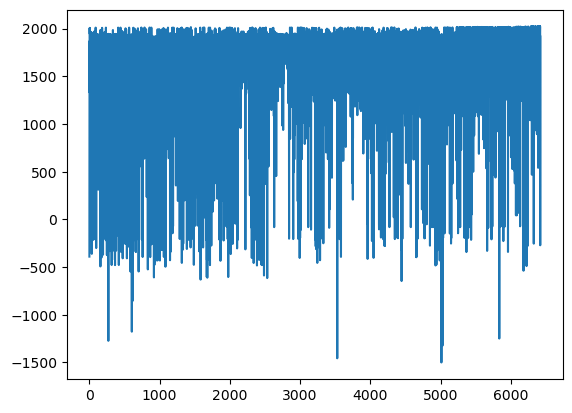

In [66]:
df_b['year'].plot()